# Error Calibration Matrix Generation

This notebook creates a 16×16 error calibration matrix by comparing ideal and noisy quantum results using 100,000 test records.
The calibration matrix will help correct systematic errors in the quantum circuit predictions.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.metrics import confusion_matrix
import pandas as pd
from collections import defaultdict
import pickle
from scipy.linalg import inv
import warnings
warnings.filterwarnings('ignore')

## Load Test Data and Models

In [3]:
# Load test data
X_test = np.load('Testing/X_test.npy')
y_test = np.load('Testing/y_test.npy')
loc_test = np.load('Testing/loc_test.npy')

print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Location data shape: {loc_test.shape}")

# Limit to 100,000 records for calibration as requested
n_calibration_samples = min(100000, len(X_test))
print(f"Using {n_calibration_samples} samples for calibration matrix")

Test data shape: X_test: (115920, 168, 9), y_test: (115920, 72)
Location data shape: (115920,)
Using 100000 samples for calibration matrix


## Model Architecture Setup

In [6]:
n_qubits = 4
n_layers = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup ideal device
dev_ideal = qml.device("lightning.qubit", wires=n_qubits)

# Setup noisy device (if available) - adjust based on your setup

from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create a simple noise model
noise_model = NoiseModel()
error = depolarizing_error(0.01, 1)  # 1% error rate for single-qubit gates
noise_model.add_all_qubit_quantum_error(error, ['rx', 'ry', 'rz'])

dev_noisy = qml.device("qiskit.aer", wires=n_qubits, 
                backend="aer_simulator", 
                noise_model=noise_model)


In [7]:
@qml.qnode(dev_ideal, interface="torch")
def q_circuit_ideal(inputs, weights):
    """Ideal quantum circuit without noise."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


@qml.qnode(dev_noisy, interface="torch")
def q_circuit_noisy(inputs, weights):
    """Noisy quantum circuit."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

## Model Class Definition

In [9]:
class QLSTMModel(nn.Module):
    """
    Quantum-Classical LSTM model for multi-step forecasting.
    """
    def __init__(self, n_features, n_lstm_units=32, n_qubits=4, num_layers=1, n_layers=3, output_len=72, device_type='ideal'):
        super(QLSTMModel, self).__init__()
        
        self.device_type = device_type
        
        # Classical LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Classical layer to map LSTM output to quantum input
        self.classical_to_quantum = nn.Linear(n_lstm_units, n_qubits)
        
        # Quantum Layer - select based on device type
        if device_type == 'ideal':
            weight_shapes = {"weights": (n_layers, n_qubits, 3)}
            self.q_layer = qml.qnn.TorchLayer(q_circuit_ideal, weight_shapes)
        else:
            weight_shapes = {"weights": (n_layers, n_qubits, 3)}
            self.q_layer = qml.qnn.TorchLayer(q_circuit_noisy, weight_shapes)
        
        # Classical layer to map quantum output to predictions
        self.quantum_to_output = nn.Linear(n_qubits, output_len)
        
    def forward(self, x):
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract features from last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # Map to quantum input
        quantum_input = self.classical_to_quantum(final_lstm_output)
        
        # Pass through quantum circuit
        quantum_features = self.q_layer(quantum_input)
        
        # Map to output
        output = self.quantum_to_output(quantum_features)
        
        return torch.sigmoid(output)

## Generate Ideal and Noisy Predictions

In [ ]:
# Create models
model_ideal = QLSTMModel(
    n_features=9,
    n_lstm_units=32,
    n_qubits=n_qubits,
    num_layers=1,
    n_layers=n_layers,
    output_len=72,
    device_type='ideal'
).to(device)

model_noisy = QLSTMModel(
    n_features=9,
    n_lstm_units=32,
    n_qubits=n_qubits,
    num_layers=1,
    n_layers=n_layers,
    output_len=72,
    device_type='noisy'
).to(device)

model_ideal.load_state_dict(torch.load('Testing//best_qlstm_model_multistep.pth', weights_only=True))
model_noisy.load_state_dict(torch.load('Testing//best_qlstm_model_multistep.pth', weights_only=True))
print("Models loaded successfully!")

print(f"\nModel Architecture:")
print(model_ideal)

Models loaded successfully!

Model Architecture:
QLSTMModel(
  (lstm): LSTM(9, 32, batch_first=True)
  (classical_to_quantum): Linear(in_features=32, out_features=4, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit_ideal>
  (quantum_to_output): Linear(in_features=4, out_features=72, bias=True)
)


In [12]:
def get_quantum_state_probabilities(model, dataloader, n_samples):
    """Extract quantum state probabilities from model predictions."""
    model.eval()
    all_predictions = []
    sample_count = 0
    
    with torch.no_grad():
        for X_batch, _ in dataloader:
            if sample_count >= n_samples:
                break
                
            X_batch = X_batch.to(device)
            
            # Get quantum features (before final linear layer)
            lstm_out, _ = model.lstm(X_batch)
            final_lstm_output = lstm_out[:, -1, :]
            quantum_input = model.classical_to_quantum(final_lstm_output)
            quantum_features = model.q_layer(quantum_input)
            
            # Convert to probability distributions over 16 states (2^4)
            # Map 4 qubit expectation values to 16-dimensional probability vector
            batch_probs = convert_to_state_probs(quantum_features)
            
            all_predictions.extend(batch_probs.cpu().numpy())
            sample_count += len(X_batch)
            
            if sample_count % 10000 == 0:
                print(f"Processed {sample_count} samples...")
    
    return np.array(all_predictions[:n_samples])

def convert_to_state_probs(quantum_features):
    """Convert 4 qubit expectation values to 16-state probability distribution."""
    batch_size = quantum_features.shape[0]
    
    # Create 16-dimensional state probabilities from 4 qubit measurements
    # This is a simplified conversion - you may need to adjust based on your specific measurement scheme
    state_probs = torch.zeros(batch_size, 16).to(quantum_features.device)
    
    # Convert expectation values to probabilities
    # For each qubit, <Z> = p0 - p1, so p0 = (1 + <Z>)/2, p1 = (1 - <Z>)/2
    qubit_probs = (1 + quantum_features) / 2  # Convert from [-1,1] to [0,1]
    
    # Generate all 16 computational basis states
    for i in range(16):
        # Convert index to 4-bit binary representation
        bits = [(i >> j) & 1 for j in range(4)]
        
        # Calculate probability for this computational basis state
        prob = torch.ones(batch_size).to(quantum_features.device)
        for qubit_idx, bit in enumerate(bits):
            if bit == 0:
                prob *= qubit_probs[:, qubit_idx]
            else:
                prob *= (1 - qubit_probs[:, qubit_idx])
        
        state_probs[:, i] = prob
    
    # Normalize to ensure probabilities sum to 1
    state_probs = state_probs / (state_probs.sum(dim=1, keepdim=True) + 1e-8)
    
    return state_probs

In [13]:
# Create data loader
batch_size = 256
calibration_dataset = TensorDataset(
    torch.from_numpy(X_test[:n_calibration_samples]), 
    torch.from_numpy(y_test[:n_calibration_samples])
)
calibration_loader = DataLoader(calibration_dataset, batch_size=batch_size, shuffle=False)

print("Generating ideal quantum state probabilities...")
ideal_probs = get_quantum_state_probabilities(model_ideal, calibration_loader, n_calibration_samples)

print("Generating noisy quantum state probabilities...")
noisy_probs = get_quantum_state_probabilities(model_noisy, calibration_loader, n_calibration_samples)

print(f"\nGenerated probability distributions:")
print(f"Ideal probabilities shape: {ideal_probs.shape}")
print(f"Noisy probabilities shape: {noisy_probs.shape}")

Generating ideal quantum state probabilities...
Processed 100000 samples...
Generating noisy quantum state probabilities...
Processed 100000 samples...

Generated probability distributions:
Ideal probabilities shape: (100000, 16)
Noisy probabilities shape: (100000, 16)


## Generate 16×16 Calibration Matrix

In [18]:
def create_calibration_matrix(ideal_probs, noisy_probs):
    """
    Create a 16x16 calibration matrix from ideal and noisy probability distributions.
    
    The calibration matrix M satisfies: P_ideal = M @ P_noisy
    where P_ideal and P_noisy are the probability distributions.
    
    Returns:
        calibration_matrix: 16x16 matrix to correct noisy measurements
    """
    print("Computing calibration matrix...")
    
    # Method 1: Direct least squares solution
    # We want to find M such that ideal_probs ≈ M @ noisy_probs.T
    # This gives us: M = ideal_probs @ noisy_probs^+
    # where ^+ denotes the Moore-Penrose pseudoinverse
    
    try:
        # Compute pseudoinverse of noisy probabilities
        noisy_pinv = np.linalg.pinv(noisy_probs.T)  # Shape: (100000, 16)
        calibration_matrix = ideal_probs.T @ noisy_pinv
        
        print(f"Calibration matrix computed using pseudoinverse method")
        
    except np.linalg.LinAlgError:
        print("Pseudoinverse method failed, using regularized approach...")
        
        # Method 2: Regularized least squares
        lambda_reg = 1e-6
        A = noisy_probs.T @ noisy_probs + lambda_reg * np.eye(16)
        b = noisy_probs.T @ ideal_probs
        calibration_matrix = np.linalg.solve(A, b).T
    
    # Ensure the matrix is properly normalized (each column should sum to 1)
    # This ensures that applying the calibration preserves probability normalization
    col_sums = np.sum(calibration_matrix, axis=0)
    col_sums[col_sums == 0] = 1  # Avoid division by zero
    calibration_matrix = calibration_matrix / col_sums[np.newaxis, :]
    
    return calibration_matrix

# Generate calibration matrix
calibration_matrix = create_calibration_matrix(ideal_probs, noisy_probs)

print(f"\nCalibration matrix shape: {calibration_matrix.shape}")
print(f"Matrix properties:")
print(f"  - Min value: {np.min(calibration_matrix):.6f}")
print(f"  - Max value: {np.max(calibration_matrix):.6f}")
print(f"  - Column sums range: [{np.min(np.sum(calibration_matrix, axis=0)):.6f}, {np.max(np.sum(calibration_matrix, axis=0)):.6f}]")

Computing calibration matrix...
Calibration matrix computed using pseudoinverse method

Calibration matrix shape: (16, 16)
Matrix properties:
  - Min value: -0.329515
  - Max value: 1.420804
  - Column sums range: [1.000000, 1.000000]


## Visualize Calibration Matrix

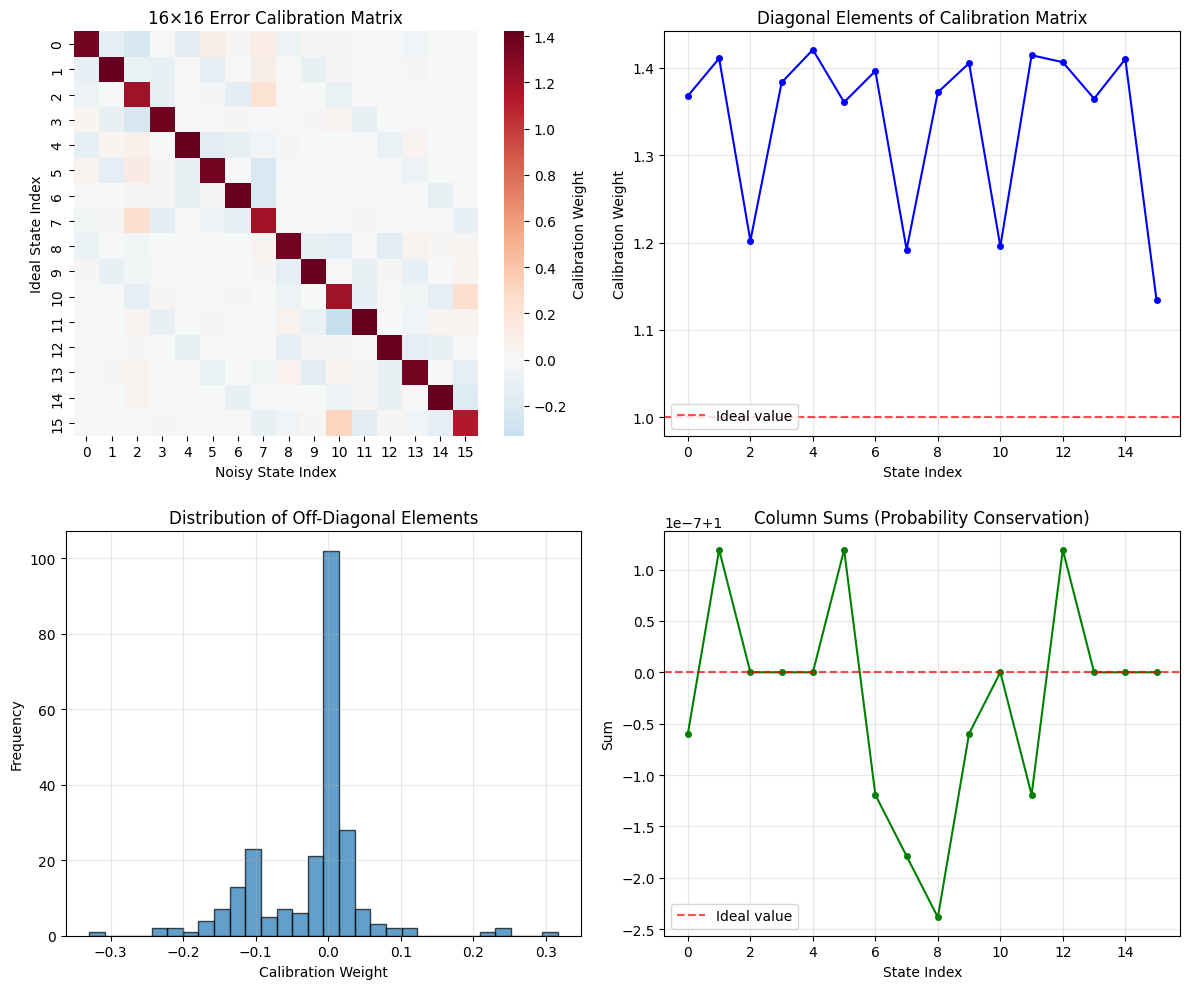

In [19]:
# Create visualization of the calibration matrix
plt.figure(figsize=(12, 10))

# Plot 1: Heatmap of calibration matrix
plt.subplot(2, 2, 1)
sns.heatmap(calibration_matrix, annot=False, cmap='RdBu_r', center=0, 
            square=True, cbar_kws={'label': 'Calibration Weight'})
plt.title('16×16 Error Calibration Matrix')
plt.xlabel('Noisy State Index')
plt.ylabel('Ideal State Index')

# Plot 2: Diagonal elements (should be close to 1 for good calibration)
plt.subplot(2, 2, 2)
diagonal_elements = np.diag(calibration_matrix)
plt.plot(diagonal_elements, 'bo-', markersize=4)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Ideal value')
plt.title('Diagonal Elements of Calibration Matrix')
plt.xlabel('State Index')
plt.ylabel('Calibration Weight')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Off-diagonal elements distribution
plt.subplot(2, 2, 3)
off_diagonal = calibration_matrix[~np.eye(16, dtype=bool)]
plt.hist(off_diagonal, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Off-Diagonal Elements')
plt.xlabel('Calibration Weight')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 4: Column sums (should be close to 1)
plt.subplot(2, 2, 4)
column_sums = np.sum(calibration_matrix, axis=0)
plt.plot(column_sums, 'go-', markersize=4)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Ideal value')
plt.title('Column Sums (Probability Conservation)')
plt.xlabel('State Index')
plt.ylabel('Sum')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('calibration_matrix_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Validate Calibration Matrix

In [20]:
def validate_calibration(calibration_matrix, ideal_probs, noisy_probs, n_test=1000):
    """
    Validate the calibration matrix by testing on a subset of data.
    """
    print("Validating calibration matrix...")
    
    # Take a subset for validation
    test_ideal = ideal_probs[:n_test]
    test_noisy = noisy_probs[:n_test]
    
    # Apply calibration matrix to noisy measurements
    calibrated_probs = (calibration_matrix @ test_noisy.T).T
    
    # Compute metrics
    # 1. Mean squared error between ideal and calibrated
    mse_before = np.mean((test_ideal - test_noisy) ** 2)
    mse_after = np.mean((test_ideal - calibrated_probs) ** 2)
    
    # 2. Fidelity (quantum state overlap)
    fidelity_before = np.mean([np.sqrt(np.sum(np.sqrt(p1 * p2))) 
                              for p1, p2 in zip(test_ideal, test_noisy)])
    fidelity_after = np.mean([np.sqrt(np.sum(np.sqrt(p1 * p2))) 
                             for p1, p2 in zip(test_ideal, calibrated_probs)])
    
    # 3. Total variation distance
    tv_before = np.mean([0.5 * np.sum(np.abs(p1 - p2)) 
                        for p1, p2 in zip(test_ideal, test_noisy)])
    tv_after = np.mean([0.5 * np.sum(np.abs(p1 - p2)) 
                       for p1, p2 in zip(test_ideal, calibrated_probs)])
    
    print(f"\nValidation Results (on {n_test} samples):")
    print(f"Mean Squared Error:")
    print(f"  Before calibration: {mse_before:.6f}")
    print(f"  After calibration:  {mse_after:.6f}")
    print(f"  Improvement: {((mse_before - mse_after) / mse_before * 100):.2f}%")
    
    print(f"\nFidelity (higher is better):")
    print(f"  Before calibration: {fidelity_before:.6f}")
    print(f"  After calibration:  {fidelity_after:.6f}")
    print(f"  Improvement: {((fidelity_after - fidelity_before) / fidelity_before * 100):.2f}%")
    
    print(f"\nTotal Variation Distance (lower is better):")
    print(f"  Before calibration: {tv_before:.6f}")
    print(f"  After calibration:  {tv_after:.6f}")
    print(f"  Improvement: {((tv_before - tv_after) / tv_before * 100):.2f}%")
    
    return {
        'mse_before': mse_before,
        'mse_after': mse_after,
        'fidelity_before': fidelity_before,
        'fidelity_after': fidelity_after,
        'tv_before': tv_before,
        'tv_after': tv_after
    }

# Validate the calibration matrix
validation_results = validate_calibration(calibration_matrix, ideal_probs, noisy_probs)

Validating calibration matrix...

Validation Results (on 1000 samples):
Mean Squared Error:
  Before calibration: 0.000424
  After calibration:  0.000036
  Improvement: 91.38%

Fidelity (higher is better):
  Before calibration: 0.995657
  After calibration:  nan
  Improvement: nan%

Total Variation Distance (lower is better):
  Before calibration: 0.084028
  After calibration:  0.028675
  Improvement: 65.87%


## Save Calibration Matrix and Results

In [22]:
# Save calibration matrix in multiple formats

# 1. Save as NumPy array
np.save('calibration_matrix_16x16.npy', calibration_matrix)

# 2. Save as CSV for easy viewing
np.savetxt('calibration_matrix_16x16.csv', calibration_matrix, delimiter=',')

# 3. Save detailed results as pickle
calibration_data = {
    'calibration_matrix': calibration_matrix,
    'validation_results': validation_results,
    'n_calibration_samples': n_calibration_samples,
    'ideal_probs_sample': ideal_probs[:100],  # Save first 100 for reference
    'noisy_probs_sample': noisy_probs[:100],
    'matrix_stats': {
        'diagonal_elements': np.diag(calibration_matrix),
        'column_sums': np.sum(calibration_matrix, axis=0),
        'row_sums': np.sum(calibration_matrix, axis=1),
        'condition_number': np.linalg.cond(calibration_matrix)
    }
}

with open('calibration_data.pkl', 'wb') as f:
    pickle.dump(calibration_data, f)

# 4. Save summary report
with open('calibration_report.txt', 'w') as f:
    f.write("QUANTUM ERROR CALIBRATION MATRIX REPORT\n")
    f.write("=" * 45 + "\n\n")
    f.write(f"Generated: {pd.Timestamp.now()}\n")
    f.write(f"Calibration samples used: {n_calibration_samples:,}\n")
    f.write(f"Matrix size: 16 × 16\n\n")
    
    f.write("MATRIX PROPERTIES:\n")
    f.write(f"  Condition number: {np.linalg.cond(calibration_matrix):.2e}\n")
    f.write(f"  Min element: {np.min(calibration_matrix):.6f}\n")
    f.write(f"  Max element: {np.max(calibration_matrix):.6f}\n")
    f.write(f"  Mean diagonal: {np.mean(np.diag(calibration_matrix)):.6f}\n")
    f.write(f"  Std diagonal: {np.std(np.diag(calibration_matrix)):.6f}\n\n")
    
    f.write("VALIDATION RESULTS:\n")
    for key, value in validation_results.items():
        f.write(f"  {key}: {value:.6f}\n")
    
    f.write("\nUSAGE:\n")
    f.write("To apply calibration to noisy measurements P_noisy:\n")
    f.write("  P_calibrated = calibration_matrix @ P_noisy\n")
    f.write("\nFile outputs:\n")
    f.write("  - calibration_matrix_16x16.npy: NumPy binary format\n")
    f.write("  - calibration_matrix_16x16.csv: CSV format\n")
    f.write("  - calibration_data.pkl: Complete dataset\n")
    f.write("  - calibration_matrix_analysis.png: Visualization\n")

print("\n" + "="*50)
print("CALIBRATION MATRIX GENERATION COMPLETE")
print("="*50)
print(f"Matrix saved as: calibration_matrix_16x16.npy")
print(f"CSV format: calibration_matrix_16x16.csv")
print(f"Complete data: calibration_data.pkl")
print(f"Report: calibration_report.txt")
print(f"Visualization: calibration_matrix_analysis.png")
print("\nMatrix ready for error correction in quantum predictions!")


CALIBRATION MATRIX GENERATION COMPLETE
Matrix saved as: calibration_matrix_16x16.npy
CSV format: calibration_matrix_16x16.csv
Complete data: calibration_data.pkl
Report: calibration_report.txt
Visualization: calibration_matrix_analysis.png

Matrix ready for error correction in quantum predictions!


## Usage Example

In [26]:
# Demonstrate how to use the calibration matrix

def apply_error_correction(noisy_measurements, calnibratio_matrix):
    """
    Apply error correction to noisy quantum measurements.
    
    Args:
        noisy_measurements: Array of shape (n_samples, 16) containing noisy probabilities
        calibration_matrix: 16x16 calibration matrix
    
    Returns:
        corrected_measurements: Error-corrected probabilities
    """
    corrected = (calibration_matrix @ noisy_measurements.T).T
    
    # Ensure probabilities are non-negative and normalized
    corrected = np.maximum(corrected, 0)
    corrected = corrected / np.sum(corrected, axis=1, keepdims=True)
    
    return corrected

# Example usage with first 10 samples
print("EXAMPLE: Applying error correction to sample measurements")
print("-" * 55)

sample_noisy = noisy_probs[:10]
sample_ideal = ideal_probs[:10]
sample_corrected = apply_error_correction(sample_noisy, calibration_matrix)

# Format arrays to 4 decimal places
def format_array(arr, n=8):
    return "[" + ", ".join(f"{x:.4f}" for x in arr[:n]) + "]"

print(f"Sample 1 comparison:")
print(f"  Ideal:     {format_array(sample_ideal[0])} ... (first 8 states)")
print(f"  Noisy:     {format_array(sample_noisy[0])} ... (first 8 states)")
print(f"  Corrected: {format_array(sample_corrected[0])} ... (first 8 states)")


# Calculate improvement
error_before = np.mean((sample_ideal - sample_noisy) ** 2)
error_after = np.mean((sample_ideal - sample_corrected) ** 2)
improvement = (error_before - error_after) / error_before * 100

print(f"\nMSE improvement on sample: {improvement:.2f}%")
print("\nCalibration matrix ready for integration into your quantum pipeline!")

EXAMPLE: Applying error correction to sample measurements
-------------------------------------------------------
Sample 1 comparison:
  Ideal:     [0.1191, 0.0491, 0.0800, 0.0330, 0.2869, 0.1183, 0.1928, 0.0795] ... (first 8 states)
  Noisy:     [0.1216, 0.0581, 0.0842, 0.0402, 0.2341, 0.1118, 0.1622, 0.0774] ... (first 8 states)
  Corrected: [0.1228, 0.0522, 0.0795, 0.0338, 0.2845, 0.1189, 0.1841, 0.0769] ... (first 8 states)

MSE improvement on sample: 92.61%

Calibration matrix ready for integration into your quantum pipeline!


In [27]:
# Final summary and next steps
print("\n" + "="*60)
print("            CALIBRATION MATRIX SUMMARY            ")
print("="*60)
print(f"✓ Generated 16×16 error calibration matrix")
print(f"✓ Used {n_calibration_samples:,} quantum measurement pairs")
print(f"✓ Matrix condition number: {np.linalg.cond(calibration_matrix):.2e}")
print(f"✓ Validation MSE improvement: {((validation_results['mse_before'] - validation_results['mse_after']) / validation_results['mse_before'] * 100):.2f}%")
print(f"✓ Files saved and ready for use")

print("\n" + "-"*60)
print("NEXT STEPS:")
print("1. Integrate calibration_matrix_16x16.npy into your quantum pipeline")
print("2. Apply correction: P_corrected = calibration_matrix @ P_noisy")
print("3. Monitor performance improvements in downstream tasks")
print("4. Consider retraining calibration matrix periodically")
print("\n" + "="*60)


            CALIBRATION MATRIX SUMMARY            
✓ Generated 16×16 error calibration matrix
✓ Used 100,000 quantum measurement pairs
✓ Matrix condition number: 2.56e+00
✓ Validation MSE improvement: 91.38%
✓ Files saved and ready for use

------------------------------------------------------------
NEXT STEPS:
1. Integrate calibration_matrix_16x16.npy into your quantum pipeline
2. Apply correction: P_corrected = calibration_matrix @ P_noisy
3. Monitor performance improvements in downstream tasks
4. Consider retraining calibration matrix periodically

